#Project goals
The aim of this project is to investigate investors' risk tolerance and their personal perception of it. Next, we will create a model that suggests the ratio of risky to safe assets so that the investor can withstand the determined allocation of assets when the risk materializes.

Data for this project comes from Survey of Consumer Finances 2007 - 2009:<br>https://www.federalreserve.gov/econres/scf_2009p.htm
<br>
Codebook:<br>https://www.federalreserve.gov/econres/files/codebk2009p.txt
<br>
The choice is not accidental, as we want to investigate how the financial crisis of 2008 influenced the financial decisions of the respondents. The idea for the data preparation comes from "Machine Learning and Data Science Blueprints for finance" by Hariom Tatsat, Sahil Puri and Brad Lookabaugh.

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Import Machine Learning tools
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

import pickle

In [ ]:
# data load time ~ 3 min
df = pd.read_excel('SCFP2009panel.xlsx')

In [ ]:
df.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,NHMORTPCT,WAGEINCPCT,BUSSEFARMINCPCT,INTDIVINCPCT,KGINCPCT,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I
0,1,11,11668.134198,47,3,12,2,1,0,2,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,270.403054,57
1,1,12,11823.456494,47,3,12,2,1,0,2,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,249.593620,57
2,1,13,11913.228354,47,3,12,2,1,0,2,...,-50.000000,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,209.233358,57
3,1,14,11929.394266,47,3,12,2,1,0,2,...,-33.333333,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,209.273158,57
4,1,15,11917.722907,47,3,12,2,1,0,2,...,-38.596491,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,232.690767,57


In [ ]:
df.shape

(19285, 515)

Our task is to summarize all risky and safe assets in the portfolios of the respondents. Then make a comparison of the obtained ratios for 2007 and 2009.

In [ ]:
# Risky assets = mutual funds + stocks + corporate bonds
df['Risky2007'] = df['NMMF07'] + df['STOCKS07'] + df['BOND07']
df['Risky2009'] = df['NMMF09'] + df['STOCKS09'] + df['BOND09']

# Safe assets = checking and saving accounts + certificates of deposit + gov bonds + cash
df['Safe2007'] = df['LIQ07'] + df['CDS07'] + df['SAVBND07'] + df['CASHLI07']
df['Safe2009'] = df['LIQ09'] + df['CDS09'] + df['SAVBND09'] + df['CASHLI09']

In [ ]:
# Calculating risk tolerance.
df['RiskTol2007'] = df['Risky2007'] / (df['Risky2007'] + df['Safe2007'])
df['RiskTol2009'] = df['Risky2009'] / (df['Risky2009'] + df['Safe2009'])

In [ ]:
df.shape

(19285, 521)

In [ ]:
# A different approach than the suggestion from the book. We will measure nominal percent change, 
# not a relative change.
df['RiskTolChange'] = df['RiskTol2009'] - df['RiskTol2007']

In [ ]:
# Dealing with missing values
df=df.dropna()
df.isna().sum().sum()

0

Let's remove people who were not interested or could not invest in 2007. Of course, we'll also accidentally remove people whose true risk tolerance is zero, but that's not a problem.

In [ ]:
df=df[df['Risky2007']>0]

In [ ]:
df.shape

(7956, 522)

Let's use the following reasonably selected columns as features for our model. <br>
**AGE07**<br>
Age of person in 2007. <br>
**EDCL07**<br>
1 = no high school, 4 = college degree.<br>
**MARRIED07**<br>
1 = married,
2 = unmarried.<br>
**OCCAT107**<br>
1 work for someone else<br> 
2 self-employed/partnership<br>
3 retired/disabled + (student/homemaker/misc. not working and age 65 or older)<br>
4 other groups not working (mainly those under 65 and out of the labor force)<br>
**KIDS07**<br>
Number of children.<br>
**WSAVED07**<br>
Spending vs income ratio. 1 spending > income, 2 spening ~ income, 3 spendng < income<br>
**NETWORTH07**<br>
Net worth of respondent.<br>
**INCOME07**<br>
Income of respondent<br>
**RISK07**<br>
Level of willingness to take risk. 1 = highest , 4 = lowest.<br>
**HHOUSES07**<br>
1 = own a home, 0 = does not own a home.<br>
**SPENDMOR07**<br>
How willing the respondent is to spend more if the assets have appreciated. 1 = is not willing at all, 5 = is willing very much.

In [ ]:
keep_columns = ['AGE07','EDCL07','MARRIED07','HHOUSES07','KIDS07','OCCAT107','WSAVED07','INCOME07','SPENDMOR07','RISK07','NETWORTH07',
                'Risky2007','Risky2009','Safe2007','Safe2009','RiskTol2007','RiskTol2009','RiskTolChange']
drop_columns = [column for column in df.columns if column not in keep_columns]

In [ ]:
df.drop(labels=drop_columns, axis=1, inplace=True)

In [ ]:
df.shape

(7956, 18)

In [ ]:
# copy of dataset for faster loading in the future
df.to_csv('data.csv')

#Exploratory data analysis

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
print("The average risk tolerance in 2007 was", round(df['RiskTol2007'].mean(),2))
print(f"Only two years later, this value decreased to {round(df['RiskTol2009'].mean(),2)},\n\
which means a change of {round(np.abs(df['RiskTolChange'].mean()*100),2)} percentage points")


The average risk tolerance in 2007 was 0.63
Only two years later, this value decreased to 0.49,
which means a change of 13.86 percentage points


Conclusion: People on average misjudged their risk tolerance (overestimated).<br>
Let's take a closer look at the data.

/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:514: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:529: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


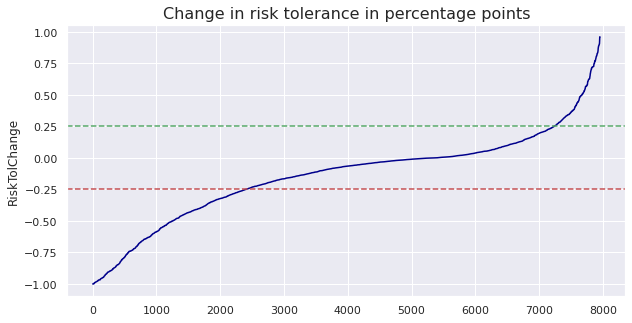

In [ ]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(10,5))
plot = sns.lineplot(data=df.sort_values('RiskTolChange').reset_index()['RiskTolChange'],c='darkblue')
plot.axhline(0.25, ls='--', c='g')
plot.axhline(-0.25, ls='--', c='r')
plt.title('Change in risk tolerance in percentage points', size=16)
plt.show()

After the financial crisis, around 30 percent of respondents decided to significantly reduce the amount of risky assets in their portfolio (by 25 percentage points or more). On the other hand, only about 10 percent of respondents increased the share of risky assets by 25+ pp.

Let's add an additional column to our dataset, which will classify whether the respondent has assessed his risk tolerance correctly.

In [ ]:
df['Smart'] = list((1 if abs(x) < 0.1 else 0 for x in df['RiskTolChange']))

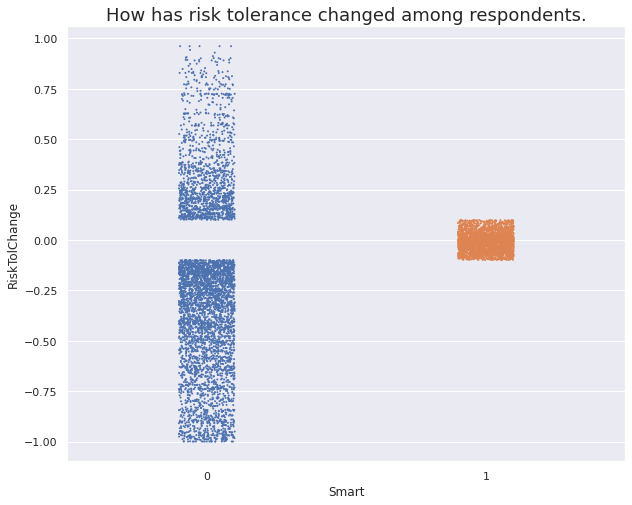

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title('How has risk tolerance changed among respondents.', size=18)
sns.stripplot(ax=ax, data=df,x="Smart",y="RiskTolChange",s=2)
plt.show()

In [ ]:
df.columns

Index(['Unnamed: 0', 'AGE07', 'EDCL07', 'MARRIED07', 'KIDS07', 'OCCAT107',
       'INCOME07', 'RISK07', 'WSAVED07', 'SPENDMOR07', 'HHOUSES07',
       'NETWORTH07', 'Risky2007', 'Risky2009', 'Safe2007', 'Safe2009',
       'RiskTol2007', 'RiskTol2009', 'RiskTolChange', 'Smart'],
      dtype='object')

We are very interested in the share of investors who have estimated their risk tolerance well, depending on other parameters. Let's take a look at the charts.

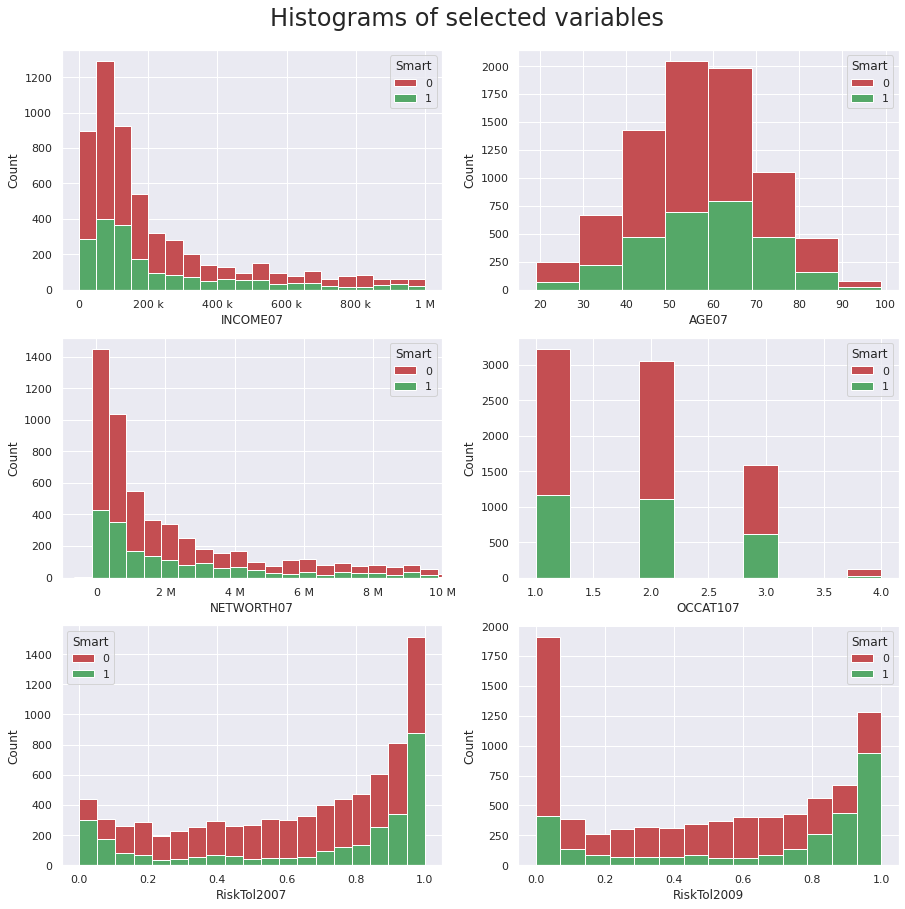

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(15,15))
fig.suptitle('Histograms of selected variables',y=0.92,fontsize=24)

ax[0,0].xaxis.set_major_formatter(ticker.EngFormatter())
sns.histplot(ax=ax[0,0], x=df[df['INCOME07']<1000000]['INCOME07'], kde=False, binwidth=50e3, hue=df['Smart'], multiple='stack',palette=["r", "g"], alpha=1)

ax[1,0].set_xlim(-10e5,10e6)
ax[1,0].xaxis.set_major_formatter(ticker.EngFormatter())
sns.histplot(ax=ax[1,0], x=df[df['NETWORTH07']<10000000]['NETWORTH07'], kde=False, binwidth=50e4, hue=df['Smart'], multiple='stack',palette=["r", "g"], alpha=1)

sns.histplot(ax=ax[0,1], x=df['AGE07'], kde=False, binwidth=10, hue=df['Smart'], multiple='stack', palette=["r", "g"], alpha=1)

sns.histplot(ax=ax[1,1], x=df['OCCAT107'], kde=False, binwidth=0.3, hue=df['Smart'], multiple='stack', palette=["r", "g"], alpha=1)

sns.histplot(ax=ax[2,0], x=df['RiskTol2007'], kde=False, bins='auto', hue=df['Smart'], multiple='stack', palette=["r", "g"], alpha=1)

sns.histplot(ax=ax[2,1], x=df['RiskTol2009'], kde=False, bins='auto', hue=df['Smart'], multiple='stack', palette=["r", "g"], alpha=1)

plt.show()

What is striking is that the older the investor, the better he estimated his resistance to fluctuations in financial markets. We also see that a lot of people who overestimated their risk tolerance eventually decided to get rid of risky assets completely in 2009 (in the stock market low). As we want to avoid such behavior, let's take a closer look at what characterizes 'Smart' investors.

In [ ]:
df.shape

(7956, 20)

In [ ]:
df_smart = df[df['Smart']==1]
df_smart['RiskTol'] = (df_smart['RiskTol2007'] + df_smart['RiskTol2009'])/2
df_smart.reset_index(drop=True, inplace=True)
df_smart.drop(labels=['Risky2007', 'Risky2009', 'Safe2007', 'Safe2009', 'RiskTol2007', 'RiskTol2009', 'RiskTolChange', 'Unnamed: 0', 'Smart'], axis=1, inplace=True)

In [ ]:
df_smart.columns

Index(['AGE07', 'EDCL07', 'MARRIED07', 'KIDS07', 'OCCAT107', 'INCOME07',
       'RISK07', 'WSAVED07', 'SPENDMOR07', 'HHOUSES07', 'NETWORTH07',
       'RiskTol'],
      dtype='object')

In [ ]:
df_smart.head(1)

,AGE07,EDCL07,MARRIED07,KIDS07,OCCAT107,INCOME07,RISK07,WSAVED07,SPENDMOR07,HHOUSES07,NETWORTH07,RiskTol
0,65,4,1,0,3,55378.767875,3,3,1,1,1.024620e+06,0.840871


Let's create a correlation matrix to see the relationship between the variables.

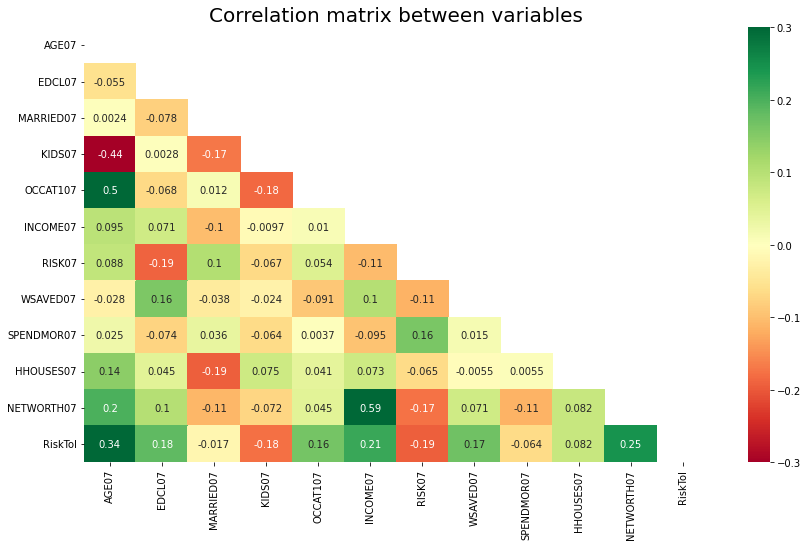

In [ ]:
corr = df_smart.corr()
mask = np.triu(np.ones_like(corr))
plt.figure(figsize=(14, 8))
plt.title('Correlation matrix between variables', fontsize = 20)
sns.heatmap(data=corr, mask=mask, vmax=0.3, vmin=-0.3, annot=True, square=False, cmap='RdYlGn')
plt.show()

Conclusion: On average, actual risk tolerance increases with age, education, earnings and wealth, and decreases with the number of children and self perception of risk tolerance.

In [ ]:
# copy of dataset for faster loading in the future
df_smart.to_csv('data_smart.csv', index=False)

# Model selection

In [ ]:
df_smart = pd.read_csv('data_smart.csv')

In [ ]:
X = df_smart.loc[:,df_smart.columns!='RiskTol']
y = df_smart['RiskTol']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
models = []

In [ ]:
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('RIDGE', Ridge()))
models.append(('SVR', SVR()))
models.append(('TREE', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

In [ ]:
# Cross validation
results = []
names = []
for name, model in models:
    results.append(cross_val_score(model, X_train, y_train, cv=10, scoring='r2'))
    names.append(name)

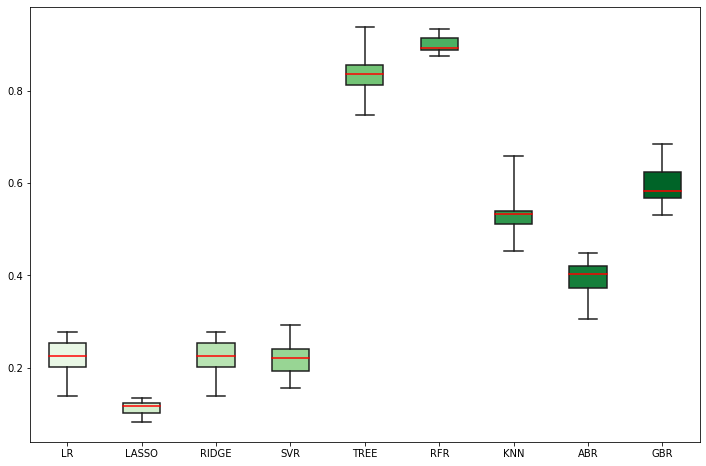

In [ ]:
# Boxplot of R2 for different models
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(ax=ax, data=results, orient='v',  palette="Greens", saturation=1, width=0.5, whis=5, medianprops=dict(color="red", alpha=1))
ax.set_xticklabels(names)
plt.show()

We can observe that Random Forest has a distinct performance advantage. Let's perform the hyperparameters tuning of this algorithm.

In [ ]:
params = {
    'n_estimators': [20, 60, 150],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split' : [2, 4],
    'min_samples_leaf' : [1, 2],
    }

In [ ]:
grid = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params, scoring='r2', cv=10)

In [ ]:
results = grid.fit(X_train, y_train)

In [ ]:
print(results.best_params_)
print(results.best_score_)

{'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 60}
0.9479381664246539


In [ ]:
# Finally tuned model
model = RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=60)

In [ ]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=60)

In [ ]:
# Another way to find r2 is by using 'r2_score' function
model.score(X_train, y_train)

0.999976518311467

In [ ]:
model.score(X_test, y_test)

0.9651795419106303

On the test sample, we achieved R2 of 0.965, which is a very good result. We managed to definitely beat the predictability of the model from the book "Machine Learning and Data Science Blueprints for Finance", for which the R2 value on the test sample was 0.761.

In [ ]:
# Saving model for future use
pickle.dump(model, open('model.sav', 'wb'))

# Predicting sample data
Let's assume that we run an investment consulting company and several clients have contacted us with a request for help with the investment. Using the model, we can quickly advise them on the ratio of risky assets in the portfolio.

In [2]:
model = pickle.load(open('model.sav', 'rb'))

In [3]:
data = pd.read_csv('to_predict.csv')

In [4]:
data.head()

,AGE07,EDCL07,MARRIED07,KIDS07,OCCAT107,INCOME07,RISK07,WSAVED07,SPENDMOR07,HHOUSES07,NETWORTH07
0,25,1,1,3,3,50000,4,1,3,0,10000
1,35,4,2,1,1,0,1,3,1,0,250000
2,60,4,2,0,4,1000000,1,3,1,1,10000000


In [5]:
data['RISK_TOL'] = model.predict(data)

In [9]:
data['RISK_TOL']

0    0.173821
1    0.533236
2    0.749501
Name: RISK_TOL, dtype: float64